# N-Gram model to cluster code into clusters

This model was based on [Kristian Wahlroos's](https://github.com/wakr/MSc-Thesis) MSc research and source code to prototype a n-gram based model, used for plagiarism detection, to instead just return the clusters as is.


In [1]:
import numpy as np
import pandas as pd
import scipy
import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns

import os
import json

In [2]:
def parse_testdata(path='../data/rainfall-submissions.tsv'):
    file = open(path,'r')
    raw = file.readlines()
    file.close()
    res = dict()
    exid = "3c79c115-0f5f-4d8e-b02c-b4b33155a4b3"
    get_code = lambda data: data["mooc-2017-ohjelmointi"]["osa02-Osa02_16.MarsinLampotilanKeskiarvo"]["/src/MarsinLampotilanKeskiarvo.java"]
    for line in raw:
        id = line[:len(exid)]
        body = json.loads(line[len(exid):])
        res[id] = get_code(body)
    return res

rain = parse_testdata()

In [3]:
import re

def normalize(source_code):
    res = re.sub("import.*;", "", source_code)
    res = re.sub("\".+\"", "\"\"", res)
    res = re.sub("\t+", "", res)
    res = re.sub("\n", "", res)
    res = re.sub("\s+", " ", res)
    res = re.sub("({|})", " ", res)
    res = re.sub("\d+", "t0", res)
    res = re.sub("(for|while)", "loop", res)
    return res

def normalize_for_ai(source_code):
    res = re.sub("\/\*.*\*\/", "", source_code, flags=re.DOTALL) # multiline comment
    res = re.sub("\/\/.*", "", res) # inline comments
    res = re.sub("\".+\"", "\"\"", res) # string values
    res = re.sub("\d+", "$", res)
    return res

def normalize_for_ast(source_code):
    res = re.sub("import.*;", "", source_code)
    res = re.sub("package.*;", "", res)
    return res


In [4]:
import antlr4
from antlr_local.generated.JavaLexer import JavaLexer
from antlr_local.generated.JavaParser import JavaParser
from antlr_local.generated.JavaParserListener import JavaParserListener
from antlr_local.MyListener import KeyPrinter

import pprint

from antlr4 import RuleContext

import glob

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

def parse_to_compositional_tokens(code):
    #print("parsing: ", self.ID)
    code_stream = antlr4.InputStream(code)
    lexer = JavaLexer(code_stream)
    token_stream = antlr4.CommonTokenStream(lexer)
    parser = JavaParser(token_stream)
    tree = parser.compilationUnit()

    printer = KeyPrinter()
    walker = antlr4.ParseTreeWalker()
    walker.walk(printer, tree)

    return printer.get_result()

def parse_data(codeDict):
    ids = list(codeDict.keys())
    token_list = [None] * len(ids)
    normalized_list = [None] * len(ids)
    for i in range(0, len(ids)):
        c = codeDict[ids[i]]
        token_list[i] = parse_to_compositional_tokens(c)
        normalized_list[i] = normalize_for_ai(c)
    return token_list, normalized_list
   

tlist, nlist = parse_data(rain)
df = pd.DataFrame({ "token_stream": tlist, "normalized": nlist })

Here is guess you can change the `ngram_range` parameter to optimize the model to use only a specific amount of ngrams. As Kristian stated in his research, a higher value will make the most unique groups even more unique but there's some optimal ratio between 3-5 n-grams. Although in my experiments it's better to use a range of n-grams such as 3-7 to find better clusters (with either OPTICS or HDBSCAN).

[t-SNE] Computing 109 nearest neighbors...
[t-SNE] Indexed 110 samples in 0.000s...
[t-SNE] Computed neighbors for 110 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 110 / 110
[t-SNE] Mean sigma: 0.563011
[t-SNE] Computed conditional probabilities in 0.007s
[t-SNE] Iteration 50: error = 52.0868607, gradient norm = 0.6036448 (50 iterations in 0.035s)
[t-SNE] Iteration 100: error = 55.1723480, gradient norm = 0.4545566 (50 iterations in 0.039s)
[t-SNE] Iteration 150: error = 53.3516769, gradient norm = 0.5021898 (50 iterations in 0.042s)
[t-SNE] Iteration 200: error = 54.3620148, gradient norm = 0.5158749 (50 iterations in 0.031s)
[t-SNE] Iteration 250: error = 55.0641136, gradient norm = 0.4474815 (50 iterations in 0.033s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.064114
[t-SNE] Iteration 300: error = 0.8512355, gradient norm = 0.0085353 (50 iterations in 0.044s)
[t-SNE] Iteration 350: error = 0.4488986, gradient norm = 0.0071557 

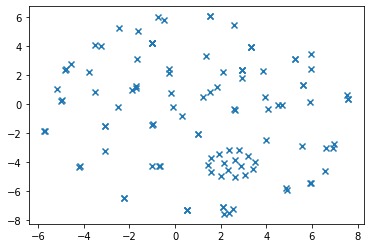

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,  TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn import manifold
from sklearn.cluster import DBSCAN, OPTICS, KMeans

from mpl_toolkits.mplot3d import Axes3D

tfidf_vectorizer = TfidfVectorizer(max_df=0.95,
                                   min_df=2,
                                   analyzer='word', 
                                   ngram_range=(5, 5),
                                   token_pattern="[\S]+",
                                   lowercase= False,
                                   strip_accents="ascii")

tfidf = tfidf_vectorizer.fit_transform(df.token_stream)

sim_matrix = np.around(cosine_similarity(tfidf, tfidf), decimals=8)
dist_matrix = np.subtract(np.ones(sim_matrix.shape,  dtype=np.int8), sim_matrix)

X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(tfidf)
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker="x")

In [6]:
ngram_vectorizer = CountVectorizer(analyzer='word', 
                                   ngram_range=(5, 5),
                                   token_pattern="[\S]+",
                                   lowercase= False,
                                   strip_accents="ascii")

#transformer = TfidfTransformer(smooth_idf=True, norm=None)
transformer = TfidfTransformer(smooth_idf=False)

X = ngram_vectorizer.fit_transform(df.token_stream)
tfidf = transformer.fit_transform(X)

res_tf = pd.DataFrame(X.A, columns=ngram_vectorizer.get_feature_names())

res_idf = pd.DataFrame(tfidf.A, columns=ngram_vectorizer.get_feature_names())

In [7]:
res_idf

,APPLY APPLY BREAK IF{ ASSIGN,APPLY APPLY BREAK }IF }IF,APPLY APPLY IF{ ASSIGN APPLY,APPLY APPLY IF{ ASSIGN ASSIGN,APPLY APPLY IF{ ASSIGN BREAK,APPLY APPLY IF{ ASSIGN VARDEF,APPLY APPLY IF{ IF{ ASSIGN,APPLY APPLY LOOP{ ASSIGN IF{,APPLY APPLY VARDEF ASSIGN IF{,APPLY APPLY VARDEF ASSIGN VARDEF,...,}LOOP APPLY APPLY }METHOD }CLASS,}LOOP ASSIGN APPLY APPLY }METHOD,}LOOP ASSIGN APPLY }METHOD }CLASS,}LOOP IF{ ASSIGN APPLY APPLY,}LOOP RETURN }METHOD METHOD{ GENERIC,}LOOP VARDEF ASSIGN APPLY APPLY,}LOOP VARDEF ASSIGN APPLY }METHOD,}LOOP VARDEF ASSIGN VARDEF ASSIGN,}METHOD METHOD{ GENERIC RETURN APPLY,}METHOD METHOD{ GENERIC VARDEF ASSIGN
0,0.0,0.0,0.000000,0.0,0.118352,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.133996,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.159535,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.108708,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.107280,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.381592,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0.0,0.0,0.248352,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
106,0.0,0.0,0.000000,0.0,0.108739,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
107,0.0,0.0,0.000000,0.0,0.128104,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.296301,0.0,0.0,0.0
108,0.0,0.0,0.000000,0.0,0.159535,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


[t-SNE] Computing 109 nearest neighbors...
[t-SNE] Indexed 110 samples in 0.000s...
[t-SNE] Computed neighbors for 110 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 110 / 110
[t-SNE] Mean sigma: 0.528240
[t-SNE] Computed conditional probabilities in 0.008s
[t-SNE] Iteration 50: error = 55.1940842, gradient norm = 0.5093169 (50 iterations in 0.053s)
[t-SNE] Iteration 100: error = 55.5126801, gradient norm = 0.5523242 (50 iterations in 0.037s)
[t-SNE] Iteration 150: error = 56.7444839, gradient norm = 0.4403482 (50 iterations in 0.039s)
[t-SNE] Iteration 200: error = 52.2317009, gradient norm = 0.5652189 (50 iterations in 0.031s)
[t-SNE] Iteration 250: error = 55.5308380, gradient norm = 0.4691649 (50 iterations in 0.034s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.530838
[t-SNE] Iteration 300: error = 0.7417300, gradient norm = 0.0070890 (50 iterations in 0.049s)
[t-SNE] Iteration 350: error = 0.6119438, gradient norm = 0.0111006 

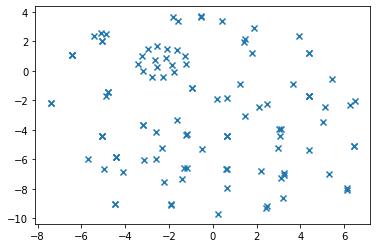

In [9]:
# TODO: Add treshold

sim_matrix = np.around(cosine_similarity(tfidf), decimals=8)
dist_matrix = np.subtract(np.ones(sim_matrix.shape,  dtype=np.int8), sim_matrix) # sim <=> 1 - dist

X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(tfidf)
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)
#%%
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker="x")

In [10]:
from sklearn.cluster import DBSCAN

db = DBSCAN(min_samples=2, metric="precomputed", eps=0.05).fit(dist_matrix)
labels = db.labels_ # -1 = noise
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels) 

labels

array([ 0,  1,  2, -1,  3,  4, -1, -1,  2, -1, -1, -1,  5, -1,  4, -1,  2,
        6, -1, -1,  2,  7, -1, -1,  8,  7, -1, -1, -1,  2,  2, -1,  2, -1,
        0, -1,  2, -1, -1, -1, -1, -1,  8, -1,  9,  6, -1, -1,  4, -1, -1,
       -1,  3,  6, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1,  2,  0, -1,
       -1, -1, -1, -1, -1, -1,  1, -1,  2, -1, -1, -1, -1,  2, -1,  9, 10,
       -1,  2, -1, -1, -1,  2,  3,  2, -1, -1,  2, -1,  7, -1, -1, -1,  5,
        4, -1, -1, -1, 10,  4,  2, -1])

In [11]:
from sklearn.metrics import silhouette_score

silhouette_score(X, labels)

0.2451390684217348

In [12]:
X

<110x380 sparse matrix of type '<class 'numpy.int64'>'
	with 2969 stored elements in Compressed Sparse Row format>

In [13]:


def create_clusters(labels):
    clusters = {}
    for i, c in enumerate(labels):
        if c == -1: continue
        if not c in clusters.keys():
            clusters[c] = [i]
        else:
            clusters[c].append(i)
    return clusters

silhouette_avg = silhouette_score(X, labels)
clusters = create_clusters(labels)

In [14]:
clusters

{0: [0, 34, 56, 66],
 1: [1, 74],
 2: [2, 8, 16, 20, 29, 30, 32, 36, 65, 76, 81, 86, 90, 92, 95, 108],
 3: [4, 52, 91],
 4: [5, 14, 48, 102, 107],
 5: [12, 101],
 6: [17, 45, 53],
 7: [21, 25, 97],
 8: [24, 42],
 9: [44, 83],
 10: [84, 106]}

In [15]:
X_embedded

array([[ 4.4027505e+00, -1.6882318e+00],
       [-9.5359617e-01, -1.1909140e+00],
       [-2.1578984e+00,  8.5265166e-01],
       [ 3.6627669e+00, -8.7946737e-01],
       [-6.4184728e+00,  1.0756114e+00],
       [-4.8537931e+00,  2.4783244e+00],
       [ 2.4135725e+00, -9.2755938e+00],
       [ 5.8841890e-01, -6.6792221e+00],
       [-2.7880847e+00, -4.1447848e-01],
       [-2.5982213e+00, -5.9636283e+00],
       [-1.5948551e+00,  3.3569827e+00],
       [ 6.6219574e-01, -1.8641376e+00],
       [-3.1905859e+00, -3.6756144e+00],
       [ 5.0519376e+00, -3.4724243e+00],
       [-5.1164556e+00,  2.5958319e+00],
       [-1.8080982e+00,  3.6628287e+00],
       [-3.2212958e+00,  9.9049711e-01],
       [-5.0470433e+00, -4.3851290e+00],
       [ 6.3989908e-01, -6.6275129e+00],
       [-4.4566255e+00, -9.0136728e+00],
       [-2.0790689e+00,  1.5084091e+00],
       [-4.3980622e+00, -5.8043017e+00],
       [ 3.1290016e+00, -7.2579713e+00],
       [-4.9849796e+00, -6.6622930e+00],
       [-5.45736

## The same model modified for the API

In [16]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn import manifold
from sklearn.cluster import DBSCAN, OPTICS, KMeans

import hdbscan
import umap

from antlr_local.java_parsers import parse_ast_complete, parse_ast_keywords, parse_ast_modified

def parse_testdata(path='../data/rainfall-submissions.tsv'):
    file = open(path,'r')
    raw = file.readlines()
    file.close()
    res = dict()
    exid = "3c79c115-0f5f-4d8e-b02c-b4b33155a4b3"
    get_code = lambda data: data["mooc-2017-ohjelmointi"]["osa02-Osa02_16.MarsinLampotilanKeskiarvo"]["/src/MarsinLampotilanKeskiarvo.java"]
    for line in raw:
        id = line[:len(exid)]
        body = json.loads(line[len(exid):])
        res[id] = get_code(body)
    return res

def counts_to_id_dict(ids, counts):
    d = {}
    for i, c in enumerate(counts):
        if None in c:
            c.pop(None)
        if len(c) != 0:
            d[ids[i]] = dict(c)
    return d

def create_clusters(labels, submissionIds):
    res = {}
    for c in set(labels):
        res[c] = [submissionIds[idx] for idx, label in enumerate(labels) if label == c]
    return res

def create_token_df(token_set, codeList):
    if token_set == 'modified':
        return pd.DataFrame({ "token_stream": parse_ast_modified(codeList) })
    elif token_set == 'complete':
        return pd.DataFrame({ "token_stream": parse_ast_complete(codeList) })
    else:
        keywords, rareKeywords = parse_ast_keywords(codeList)
        return pd.DataFrame({ "token_stream": list(map(lambda x: ' '.join(x), keywords)) })

def cluster_dist_matrix(dist_matrix, clustering_params):
    params = clustering_params or {}
    name = params.get('name')
    if name == 'DBSCAN' or name is None:
        min_samples = params.get('min_samples') or 5
        eps = params.get('eps') or 0.5
        metric = 'precomputed'
        dbscan = DBSCAN(min_samples=min_samples, metric=metric, eps=eps).fit(dist_matrix)
        return dbscan.labels_
    elif name == 'HDBSCAN':
        min_cluster_size = params.get('min_cluster_size') or 2
        min_samples = params.get('min_samples') or 5
        metric = 'precomputed'
        show_linkage_tree = params.get('show_linkage_tree') or False
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            metric=metric,
            gen_min_span_tree=show_linkage_tree
        )
        clusterer.fit(dist_matrix)
        #plt.figure(3, figsize=(24,8)) 
        #clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
        return clusterer.labels_
    elif name == 'OPTICS':
        min_samples = params.get('min_samples') or 5
        max_eps = params.get('max_eps') or np.inf
        if int(max_eps) == -1:
            max_eps = np.inf
        metric = 'precomputed'
        optics = OPTICS(min_samples=min_samples, metric=metric, max_eps=max_eps).fit(dist_matrix)
        return optics.labels_
    elif name == 'KMeans':
        n_clusters = params.get('k_clusters') or 8
        kmeans = KMeans(n_clusters=n_clusters).fit(dist_matrix)
        return kmeans.labels_
    else:
        raise ValueError(f'cluster_dist_matrix(): Unknown clustering method name: {name}')

def reduce_to_2d(tfidf, dim_visualization_params={}):
    params = dim_visualization_params or {}
    name = params.get('name')
    if name == 'UMAP':
        n_neighbors = params.get('n_neighbors') or 30
        min_dist = params.get('min_dist') or 0.0
        return umap.UMAP(
            n_components=2,
            n_neighbors=n_neighbors,
            min_dist=min_dist,
        ).fit_transform(tfidf)
    else:
        perplexity = params.get('perplexity') or 30
        svd_n_components = params.get('svd_n_components')
        matrix = tfidf
        if svd_n_components is not None:
            matrix = TruncatedSVD(
                n_components=svd_n_components,
                random_state=0
            ).fit_transform(tfidf)
        return TSNE(
            n_components=2,
            perplexity=perplexity
        ).fit_transform(matrix)

def run_ngram(submissionIds, codeList, token_set='modified', ngrams=(3,3), random_seed=-1,
              clustering_params={}, dim_visualization_params={}):

    documents = len(codeList)
    df = create_token_df(token_set, codeList)

    if random_seed != -1:
        np.random.seed(random_seed)

    tfidf_vectorizer = TfidfVectorizer(max_df=0.95,
                                    min_df=2,
                                    analyzer='word', 
                                    ngram_range=ngrams,
                                    token_pattern="[\S]+",
                                    lowercase= False,
                                    strip_accents="ascii")

    tfidf = tfidf_vectorizer.fit_transform(df.token_stream)

    sim_matrix = np.around(cosine_similarity(tfidf), decimals=8)
    dist_matrix = np.subtract(np.ones(sim_matrix.shape, dtype=np.int8), sim_matrix) # sim <=> 1 - dist

    X_embedded = reduce_to_2d(tfidf, dim_visualization_params)

    labels = cluster_dist_matrix(dist_matrix, clustering_params)

    clusters = create_clusters(labels, submissionIds)
    coordinates = [{
        'id': submissionIds[i],
        'x': d[0],
        'y': d[1],
        'cluster': labels[i]
        } for (i, d) in enumerate(X_embedded)]

    return {
        "clusters": clusters,
        "2d": coordinates,
        "tfidf": tfidf,
        "mat": dist_matrix
    }


In [17]:
import psycopg2
from dotenv import load_dotenv

import os
import json

load_dotenv()

POSTGRES_HOST = os.getenv("DB_HOST")
POSTGRES_PORT = os.getenv("DB_PORT")
POSTGRES_DB = os.getenv("DB_NAME")
POSTGRES_USER = os.getenv("DB_USER")
POSTGRES_PASSWORD = os.getenv("DB_PASSWORD")

conn = psycopg2.connect(host=POSTGRES_HOST, port=POSTGRES_PORT, database=POSTGRES_DB, user=POSTGRES_USER, password=POSTGRES_PASSWORD)

cur = conn.cursor()

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

def query_many(query):
    cur.execute(query)
    return cur.fetchall()

def cluster_submissions(courseId, exerciseId):
    rows = query_many(f"""
    SELECT submission_id, code FROM submission WHERE course_id = {courseId} AND exercise_id = {exerciseId}
    """)
    submissionIds = [r[0] for r in rows]
    codeList = [r[1] for r in rows]
    token_set = 'complete'
    ngrams = [3, 6]
    random_seed = 1
    clustering_params = {
        'name': 'HDBSCAN',
        'min_cluster_size': 2,
        'k_clusters': 3
    }
    dim_visualization_params = {
        'name': 'UMAP',
        'perplexity': 30
    }

    ngram_result = run_ngram(submissionIds, codeList, token_set, ngrams, random_seed,
      clustering_params, dim_visualization_params)
    return {
        "ngram": ngram_result
    }


res = cluster_submissions(2, 4)

/Users/teemu/.virtualenvs/cc/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11003. The TBB threading layer is disabled.
  warnings.warn(problem)


In [18]:
res['ngram']['mat']

array([[0.        , 0.80085103, 0.36957066, ..., 0.89663518, 0.59196968,
        0.7861508 ],
       [0.80085103, 0.        , 0.82859523, ..., 0.60974042, 0.84440787,
        0.4284853 ],
       [0.36957066, 0.82859523, 0.        , ..., 0.88844545, 0.68806688,
        0.57007058],
       ...,
       [0.89663518, 0.60974042, 0.88844545, ..., 0.        , 0.78038092,
        0.74686281],
       [0.59196968, 0.84440787, 0.68806688, ..., 0.78038092, 0.        ,
        0.82802399],
       [0.7861508 , 0.4284853 , 0.57007058, ..., 0.74686281, 0.82802399,
        0.        ]])

In [19]:
tfidf = res['ngram']['tfidf']
cosine_similarity(tfidf.todense())

array([[1.        , 0.19914897, 0.63042934, ..., 0.10336482, 0.40803032,
        0.2138492 ],
       [0.19914897, 1.        , 0.17140477, ..., 0.39025958, 0.15559213,
        0.5715147 ],
       [0.63042934, 0.17140477, 1.        , ..., 0.11155455, 0.31193312,
        0.42992942],
       ...,
       [0.10336482, 0.39025958, 0.11155455, ..., 1.        , 0.21961908,
        0.25313719],
       [0.40803032, 0.15559213, 0.31193312, ..., 0.21961908, 1.        ,
        0.17197601],
       [0.2138492 , 0.5715147 , 0.42992942, ..., 0.25313719, 0.17197601,
        1.        ]])

In [20]:
params = {
    'name': 'DBSCAN',
    'min_cluster_size': 2,
    'k_clusters': 3
}
min_samples = params.get('min_samples') or 5
eps = params.get('eps') or 0.5
metric = params.get('metric') or 'cosine'
dbscan = DBSCAN(min_samples=min_samples, metric=metric, eps=eps).fit(tfidf.toarray())
dbscan.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0])

In [21]:
params = {
    'name': 'HDBSCAN',
    'min_cluster_size': 2,
    'k_clusters': 3
}
min_cluster_size = params.get('min_cluster_size') or 2
min_samples = params.get('min_samples') or 5
metric = params.get('metric') or 'cosine'
show_linkage_tree = params.get('show_linkage_tree') or False
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size,
    min_samples=min_samples,
    metric=metric,
    gen_min_span_tree=show_linkage_tree
)
clusterer.fit(tfidf)
#plt.figure(3, figsize=(24,8)) 
#clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
clusterer.labels_

array([ 0, -1, -1, -1, -1, -1, -1, -1, -1,  4, -1,  4, -1, -1,  3, -1, -1,
       -1, -1, -1,  4,  0, -1,  4, -1, -1,  1, -1, -1,  0, -1, -1, -1, -1,
       -1, -1, -1, -1,  2, -1, -1, -1, -1, -1, -1, -1, -1,  2, -1,  0, -1,
       -1, -1,  4, -1, -1, -1, -1, -1, -1,  0, -1, -1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1,  4,  2,  3, -1, -1,  3,  2, -1,
       -1,  4, -1, -1,  2, -1,  4, -1, -1, -1, -1, -1, -1, -1,  3,  4, -1,
        0,  2, -1, -1, -1, -1, -1,  2])

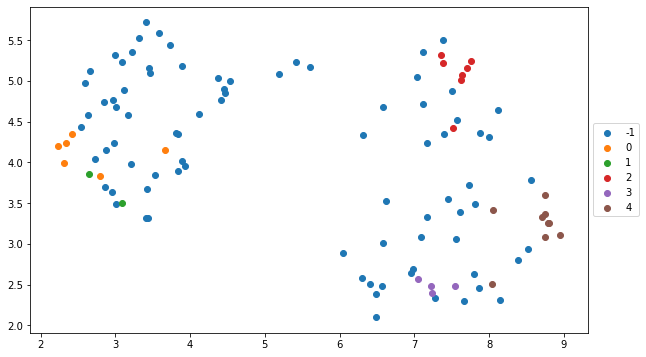

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

cluster = [x['cluster'] for x in res['ngram']['2d']]

plt.figure(3, figsize=(10,6)) 

for i, c in enumerate(np.unique(cluster)):
    x = [x['x'] for x in res['ngram']['2d'] if x['cluster'] == c]
    y = [x['y'] for x in res['ngram']['2d'] if x['cluster'] == c]
    plt.scatter(x, y, marker="o", cmap='jet', label=c)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

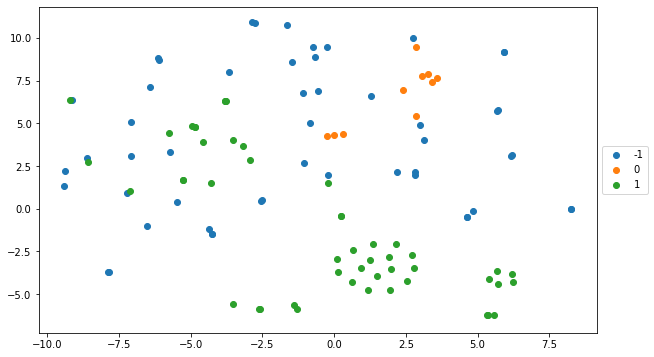

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

cluster = [x['cluster'] for x in res['ngram']['2d']]

plt.figure(3, figsize=(10,6)) 

for i, c in enumerate(np.unique(cluster)):
    x = [x['x'] for x in res['ngram']['2d'] if x['cluster'] == c]
    y = [x['y'] for x in res['ngram']['2d'] if x['cluster'] == c]
    plt.scatter(x, y, marker="o", cmap='jet', label=c)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [257]:
len([c for c in cluster if c != -1])

59

In [260]:
len(np.unique(matrix[matrix > 0.49]))

58

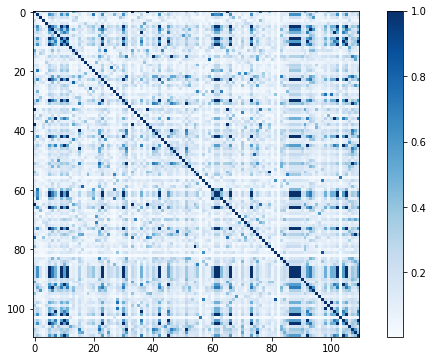

In [241]:
matrix = res['ngram']['matrix']
#matrix = np.subtract(np.ones(matrix.shape, dtype=np.int8), matrix)

plt.figure(3, figsize=(10,6))
plt.imshow(matrix, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.show()

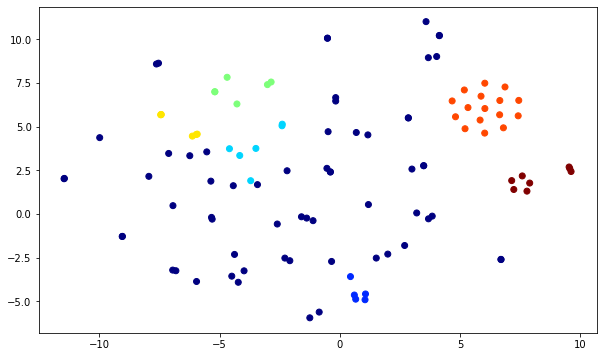

In [110]:
x = [x['x'] for x in res['ngram']['2d']]
y = [x['y'] for x in res['ngram']['2d']]
cluster = [x['cluster'] for x in res['ngram']['2d']]

plt.figure(3,figsize=(10,6)) 
plt.scatter(x, y, c=cluster, marker="o", cmap='jet')
#plt.legend(loc="upper left")
#plt.gca().legend(('y0','y1'))
plt.show()